In [1]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

In [2]:
import IPython


def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [3]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [6]:
def read_data():
    INPUT_DIR = f""

    print("Reading files...")

    calendar = pd.read_csv(f"{INPUT_DIR}calendar.csv").pipe(reduce_mem_usage)
    prices = pd.read_csv(f"{INPUT_DIR}sell_prices.csv").pipe(reduce_mem_usage)

    #sales = pd.read_csv(f"{INPUT_DIR}/sales_train_validation.csv",).pipe(
    #    reduce_mem_usage
    #)
    sales = pd.read_csv(f"{INPUT_DIR}sales_train_evaluation.csv",).pipe(
        reduce_mem_usage
    )
    submission = pd.read_csv(f"{INPUT_DIR}sample_submission.csv").pipe(
        reduce_mem_usage
    )

    print("sales shape:", sales.shape)
    print("prices shape:", prices.shape)
    print("calendar shape:", calendar.shape)
    print("submission shape:", submission.shape)

    # calendar shape: (1969, 14)
    # sell_prices shape: (6841121, 4)
    # sales_train_val shape: (30490, 1919)
    # submission shape: (60980, 29)

    return sales, prices, calendar, submission

In [7]:
sales, prices, calendar, submission = read_data()

NUM_ITEMS = sales.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1  # 28

Reading files...
sales shape: (30490, 1947)
prices shape: (6841121, 4)
calendar shape: (1969, 14)
submission shape: (60980, 29)


In [8]:
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df


calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales = encode_categorical(
    sales, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

prices = encode_categorical(prices, ["item_id", "store_id"]).pipe(reduce_mem_usage)

In [14]:
def extract_num(ser):
    return ser.str.extract(r"(\d+)").astype(np.int16)


def reshape_sales(sales, submission, d_thresh=0, verbose=True):
    # melt sales data, get it ready for training
    # change column names.

    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
    #vals_columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    evals_columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]
    # separate test dataframes.
    #vals = sales[vals_columns]#submission[submission["id"].str.endswith("validation")]
    evals = submission[submission["id"].str.endswith("evaluation")]

    # get product table.
    
    
    product = sales[id_columns]
    sales = sales.melt(id_vars=id_columns, var_name="d", value_name="demand",)
    sales = reduce_mem_usage(sales)


    #vals.columns  = vals_columns#["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    evals.columns = evals_columns#["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

    # merge with product table
    # may be edit
    #vals["id"] = vals["id"].str.replace("_validation", "_evaluation")
    #vals = vals.merge(product, how="left", on="id")
    evals = evals.merge(product, how="left", on="id")
    #vals["id"] = vals["id"].str.replace("_evaluation","_validation")
    if verbose:
    #print("validation")
    #display(vals)

        print("evaluation")
        display(evals)

    #vals = vals.melt(id_vars=id_columns, var_name="d", value_name="demand")
    evals = evals.melt(id_vars=id_columns, var_name="d", value_name="demand")

    sales["part"] = "train"
    #sales["part"][~(sales["d"]<1914)] = "validation"
    evals["part"] = "evaluation"

    data = pd.concat([sales, evals], axis=0)

    del sales, evals

    data["d"] = extract_num(data["d"])
    data = data[data["d"] >= d_thresh]

    # delete evaluation for now.
    # data = data[data["part"] != "evaluation"]

    gc.collect()

    if verbose:
        print("data")
        display(data)

    return data


def merge_calendar(data, calendar):
    calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1)
    return data.merge(calendar, how="left", on="d")
def merge_prices(data, prices):
    return data.merge(prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])

In [15]:
data = reshape_sales(sales, submission, d_thresh=1941 - int(365 * 2  + 7))
del sales
gc.collect()

calendar["d"] = extract_num(calendar["d"])
data = merge_calendar(data, calendar)
del calendar
gc.collect()

data = merge_prices(data, prices)
del prices
gc.collect()

data = reduce_mem_usage(data)

evaluation


,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0


data


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part
36679470,HOBBIES_1_001_CA_1_evaluation,1437,3,1,0,0,1204,0,train
36679471,HOBBIES_1_002_CA_1_evaluation,1438,3,1,0,0,1204,0,train
36679472,HOBBIES_1_003_CA_1_evaluation,1439,3,1,0,0,1204,0,train
36679473,HOBBIES_1_004_CA_1_evaluation,1440,3,1,0,0,1204,4,train
36679474,HOBBIES_1_005_CA_1_evaluation,1441,3,1,0,0,1204,1,train


In [16]:
def add_demand_features(df):
    # DAYS_PRED = 28,then
    for diff in [0, 28]:
        shift = DAYS_PRED + diff
        df[f"shift_t{shift}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(shift)
        )
    print("shift done")
    gc.collect()
    ### I edited diff parameters. 
    ### we predict 28 days ahead, so I created diff and roll features 
    ### based on 28 days.
    diff = 28
    for window in [28, 56, 84]:
        df[f"shift_t{diff}_rolling_std_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(diff).rolling(window).std()
        )
        df[f"shift_t{diff}_rolling_mean_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(diff).rolling(window).mean()
        )
        df[f"rolling_min_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(diff).rolling(window).min()
        )
        df[f"rolling_max_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(diff).rolling(window).max()
        )
        df[f"rolling_sum_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(diff).rolling(window).sum()
        )
    print("window done")
    df["rolling_skew_t28"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(28).skew()
    )
    df["rolling_kurt_t28"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(28).kurt()
    )
    return df


def add_price_features(df):
    df["shift_price_t1"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1)
    )
    df["price_change_t1"] = (df["shift_price_t1"] - df["sell_price"]) / (
        df["shift_price_t1"]
    )
    df["rolling_price_max_t365"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    df["price_change_t365"] = (df["rolling_price_max_t365"] - df["sell_price"]) / (
        df["rolling_price_max_t365"]
    )

    df["rolling_price_std_t7"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(7).std()
    )
    df["rolling_price_std_t30"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(30).std()
    )
    return df.drop(["rolling_price_max_t365", "shift_price_t1"], axis=1)


def add_time_features(df, dt_col):
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = [
        "year",
        "quarter",
        "month",
        "week",
        "day",
        "dayofweek",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df[dt_col].dt, attr).astype(dtype)

    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    df['month_day']  = df['month'] * 100 + df['day']
    return df



## Kien has added some features, but not worked...
def add_original_features(df):
    df['shift_t28_log']   = np.log(df['shift_t28'] + 1)
    df['shift_t28_sqrt']  = np.sqrt(df['shift_t28'])
    df['shift_t56_log']   = np.log(df['shift_t56'] + 1)
    df['shift_t56_sqrt']  = np.sqrt(df['shift_t56'])

    df['shift_t28_diff_t7'] = df.groupby('id')['shift_t28'].diff(7)
    df['shift_t56_diff_t7'] = df.groupby('id')['shift_t56'].diff(7)
    
    return df
    

In [17]:
data = add_demand_features(data).pipe(reduce_mem_usage)
print('add_demand_features done')
data = add_price_features(data).pipe(reduce_mem_usage)
print('add_price_features done')
data = add_original_features(data).pipe(reduce_mem_usage)
print('add_original_features done')
dt_col = "date"
data = add_time_features(data, dt_col).pipe(reduce_mem_usage)
data = data.sort_values("date")

print("start date:", data[dt_col].min())
print("end date:", data[dt_col].max())
print("data shape:", data.shape)

shift done
window done
add_demand_features done
add_price_features done
add_original_features done
start date: 2014-05-16 00:00:00
end date: 2016-06-19 00:00:00
data shape: (23355340, 56)


In [20]:
class CustomTimeSeriesSplitter:   
    def __init__(self, n_splits=5, train_days=80, test_days=20, day_col="d"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.day_col = day_col

    def split(self, X, y=None, groups=None):
        SEC_IN_DAY = 3600 * 24
        sec = (X[self.day_col] - X[self.day_col].iloc[0]) * SEC_IN_DAY
        duration = sec.max()

        train_sec = self.train_days * SEC_IN_DAY
        test_sec = self.test_days * SEC_IN_DAY
        total_sec = test_sec + train_sec

        if self.n_splits == 1:
            train_start = duration - total_sec
            train_end = train_start + train_sec

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = sec >= train_end

            yield sec[train_mask].index.values, sec[test_mask].index.values

        else:
            # step = (duration - total_sec) / (self.n_splits - 1)
            step = DAYS_PRED * SEC_IN_DAY

            for idx in range(self.n_splits):
                # train_start = idx * step
                shift = (self.n_splits - (idx + 1)) * step
                train_start = duration - total_sec - shift
                train_end = train_start + train_sec
                test_end = train_end + test_sec

                train_mask = (sec > train_start) & (sec <= train_end)

                if idx == self.n_splits - 1:
                    test_mask = sec > train_end
                else:
                    test_mask = (sec > train_end) & (sec <= test_end)

                yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

In [21]:
day_col = "d"
cv_params = {
    "n_splits": 3,
    "train_days": int(365 * 1.5),
    "test_days": 28,#DAYS_PRED,
    "day_col": day_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)

In [22]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features
    "shift_t28",
    "shift_t56",
    # std
    "shift_t28_rolling_std_t28",
    "shift_t28_rolling_std_t56",
    "shift_t28_rolling_std_t84",
    # mean
    "shift_t28_rolling_mean_t28",
    "shift_t28_rolling_mean_t56",
    "shift_t28_rolling_mean_t84",
    # min,
    "rolling_min_t28",
    # max
    "rolling_max_t28",
    "rolling_max_t56",
    # sum
    "rolling_sum_t28",    
    "rolling_sum_t56",        
    "rolling_kurt_t28",    
    "price_change_t365",
    "rolling_price_std_t30",
    # time features
    "year",
    "quarter",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend",
    "month_day",
    # original features
    "shift_t28_log",
    "shift_t28_sqrt",
    "shift_t56_log",
    "shift_t56_sqrt",
    "shift_t28_diff_t7",
    'shift_t56_diff_t7'
    #"self_diff_t7",
    #"self_diff_t28"
    
]
# prepare training and test data.
# 2011-01-29 ~ 2016-04-24 : d_1    ~ d_1913
# 2016-04-25 ~ 2016-05-22 : d_1914 ~ d_1941 (public)
# 2016-05-23 ~ 2016-06-19 : d_1942 ~ d_1969 (private)

is_train = (data["d"] < 1942)# & (data["d"]>=1544)

is_private = (data["d"] >= 1942)
is_public = ~(data["d"] < 1914) & ~(is_private)


# Attach "d" to X_train for cross validation.
X_train = data[is_train][[day_col] + features].reset_index(drop=True)
y_train = data[is_train]["demand"].reset_index(drop=True)
X_test_pub = data[is_public][features].reset_index(drop=True)
X_test_pri = data[is_private][features].reset_index(drop=True)

# keep these two columns to use later.
id_date_pub = data[is_public][["id", "date"]].reset_index(drop=True)
id_date_pri = data[is_private][["id", "date"]].reset_index(drop=True)

del data
gc.collect()

print(X_train['d'][0])
print("X_train shape:", X_train.shape)
print("X_test_pub shape:", X_test_pub.shape)
print("X_test_pri shape:", X_test_pri.shape)
print("id_date_pub shape:", id_date_pub.shape)
print("id_date_pri shape:", id_date_pri.shape)

1204
X_train shape: (22501620, 44)
X_test_pub shape: (853720, 43)
X_test_pri shape: (853720, 43)
id_date_pub shape: (853720, 2)
id_date_pri shape: (853720, 2)


In [23]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n----- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) -----\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        
        print(f'\n train d min: {X_trn["d"].min()} \n valid d min: {X_val["d"].min()} \n')
        
        train_set = lgb.Dataset(
            X_trn.drop(drop_when_train, axis=1),
            label=y_trn,
            categorical_feature=["item_id"],
        )
        val_set = lgb.Dataset(
            X_val.drop(drop_when_train, axis=1),
            label=y_val,
            categorical_feature=["item_id"],
        )
        eval_result = {}
        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            evals_result=eval_result,
            **fit_params,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models, eval_result

In [ ]:
bst_params =  {'lambda_l1': 0.00021301070633699974,
               'lambda_l2': 9.242591106708853e-07,
               'num_leaves': 31, 
               'feature_fraction': 0.584,
               'bagging_fraction': 1.0, 
               'bagging_freq': 0, 
               'min_child_samples': 20, 
               'boosting_type': 'gbdt',
               'metric': 'rmse',
               'objective': 'poisson',
               'n_jobs': -1,
               'seed': 42,
               'learning_rate': 0.03,
               'min_data_in_leaf': 20}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 100,
    "verbose_eval": 100,
}

models, evals = train_lgb(
    bst_params, fit_params, X_train, y_train, cv, drop_when_train=[day_col]
)

del X_train, y_train
gc.collect()

In [25]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

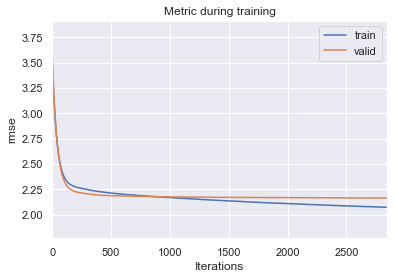

In [26]:
lgb.plot_metric(evals)

In [27]:
imp_type = "gain"
importances = np.zeros(X_test_pub.shape[1])
preds_pub = np.zeros(X_test_pub.shape[0])
preds_pri = np.zeros(X_test_pri.shape[0])

for model in models:
    importances += model.feature_importance(imp_type)

preds_pub = models[2].predict(X_test_pub)
preds_pri = models[2].predict(X_test_pri)
importances = importances / cv.get_n_splits()

In [30]:
from mlflow_extend import mlflow, plotting as mplt

with mlflow.start_run():
    mlflow.log_params_flatten({"bst": bst_params, "fit": fit_params, "cv": cv_params})


features = models[0].feature_name()
_ = mplt.feature_importance(features, importances, imp_type, limit=30)


ModuleNotFoundError: No module named 'mlflow_extend'

In [31]:

def make_submission(test_pub, test_pri, submission):
    preds_pub = test_pub[["id", "date", "demand"]]
    preds_pub['id'] = preds_pub['id'].str.replace("_evaluation", "_validation")
    print(preds_pub['id'].head())
    preds_pri = test_pri[["id", "date", "demand"]]
    # 01-28: validation
    # 29-56: evaluation
    val_dur  = preds_pub["date"]<"2016-05-23"

    preds_val  = preds_pub[val_dur]
    preds_eval = preds_pri#[eval_dur]

    preds_val = preds_val.pivot(index="id", columns="date", values="demand").reset_index()
    preds_eval = preds_eval.pivot(index="id", columns="date", values="demand").reset_index()
    
    print(preds_val.shape)
    print(preds_eval.shape)
    
    
    preds_val.columns = ["id"] + ["F" + str(d+1) for d in range(28)]
    preds_eval.columns = ["id"] + ["F" + str(d+1) for d in range(28)]
    
    
    preds_val = preds_val[preds_val['id'].str.endswith("validation")]
    preds_eval = preds_eval[preds_eval['id'].str.endswith("evaluation")]
    
    
    vals = submission[submission["id"].str.endswith("validation")]
    vals = submission[["id"]].merge(preds_val, how="inner", on="id")
    
    evals = submission[submission["id"].str.endswith("evaluation")]
    evals = submission[["id"]].merge(preds_eval, how="inner", on="id")
    
    final = pd.concat([vals, evals])
    
    
    return final

In [32]:
output = make_submission(id_date_pub.assign(demand=preds_pub), id_date_pri.assign(demand=preds_pri), submission)

0    FOODS_2_204_TX_3_validation
1    FOODS_2_205_TX_3_validation
2    FOODS_2_206_TX_3_validation
3    FOODS_2_207_TX_3_validation
4    FOODS_2_208_TX_3_validation
Name: id, dtype: object
(30490, 29)
(30490, 29)


In [33]:
output.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.949214,0.825755,0.801805,0.776261,0.861432,1.037444,1.142286,0.850857,0.882305,0.829023,0.878999,0.954207,1.176384,1.179002,0.913694,0.865968,0.831039,0.868579,0.935008,1.258279,1.232557,0.883981,0.796906,0.782032,0.875289,0.899767,1.242750,1.199066
1,HOBBIES_1_002_CA_1_validation,0.290308,0.275831,0.273626,0.265327,0.298306,0.372249,0.334542,0.220086,0.218975,0.208007,0.194950,0.229851,0.267562,0.244467,0.179895,0.178044,0.181757,0.182087,0.212525,0.267107,0.274328,0.183325,0.181818,0.211748,0.183824,0.196698,0.220175,0.198189
2,HOBBIES_1_003_CA_1_validation,0.359487,0.376895,0.375059,0.374230,0.429290,0.483491,0.511802,0.301154,0.306615,0.282930,0.334651,0.336924,0.401536,0.382881,0.255557,0.269100,0.306714,0.360110,0.427441,0.547142,0.659380,0.420604,0.452884,0.459551,0.447200,0.524265,0.674415,0.723182
3,HOBBIES_1_004_CA_1_validation,1.762266,1.508199,1.531390,1.523466,1.820035,2.258010,2.621336,1.853785,1.789425,1.604960,1.508914,1.953116,2.657164,2.560383,2.063373,1.716288,1.804200,1.601382,1.894729,2.303395,2.669098,2.061239,1.552936,1.559652,1.506441,1.814108,2.601323,2.481779
4,HOBBIES_1_005_CA_1_validation,1.044809,0.910690,0.999224,1.060849,1.029236,1.397226,1.707944,1.220890,1.177766,1.081367,1.116534,1.141125,1.507096,1.434633,1.213148,0.981842,0.994486,1.023726,1.187791,1.438827,1.453591,1.052240,0.943590,0.925726,0.958663,1.135060,1.473870,1.685178


In [34]:
output.to_csv("submission_private.csv", index=False)